In [2]:
import os
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pds
from sklearn.metrics import accuracy_score
import methods

## 数据读取

### 读取结果数据

In [35]:
datadir = 'report_transfer'
data_list = sorted(os.listdir(path=datadir))
if '.DS_Store' in data_list:
    data_list.remove('.DS_Store')

trainAcc = []
testAcc = []
trainLabel = []
testLabel = []
AllLabel = []
for filename in data_list:
    if filename.split('.')[-1] == 'npy':
        path=os.path.join(datadir, filename)
        REPORT = np.load(path,allow_pickle=True).item()

        trainAcc.append(REPORT['train_acc'])
        testAcc.append(REPORT['test_acc'])
        trainLabel.append(REPORT['TrainLabel'])
        AllLabel.append(REPORT['AllLabeSet'])
        # trainLabel.append(REPORT['TrainLabel'])
        # testLabel.append(REPORT['TestLabel'])

trainAcc = np.stack(trainAcc[i] for i in range(len(trainAcc)))
testAcc = np.stack(testAcc[i] for i in range(len(testAcc)))
AllLabel = np.stack(AllLabel[i] for i in range(len(AllLabel)))
trainLabel = np.stack(trainLabel[i] for i in range(len(trainLabel)))

# trainLabel = np.stack(trainLabel[i] for i in range(len(trainLabel)))
# testLabel = np.stack(testLabel[i] for i in range(len(testLabel)))

In [68]:
trainLabel.shape

(6, 2, 35, 200)

In [55]:
snorkel = trainLabel[:,-1,:,:]
fbLabelset = AllLabel[:,:,:,0]
standardLabel = trainLabel[:,0,:,:]
expNUM,subNUM,_,_ = AllLabel.shape

In [62]:
Acc = np.zeros((expNUM,subNUM,2))
for expInx in range(expNUM):
    for subInx in range(subNUM):
        fb_acc = accuracy_score(standardLabel[expInx,subInx,:],fbLabelset[expInx,subInx,:])
        snorkel_acc = accuracy_score(standardLabel[expInx,subInx,:],snorkel[expInx,subInx,:])
        Acc[:,:,0] = fb_acc
        Acc[:,:,-1] = snorkel_acc


In [63]:
Acc

array([[[0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725]],

       [[0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725, 0.725],
        [0.725

In [3]:
windowNUM,blockNUM = 7,4
_,methodNUM,subNUM = trainAcc.shape
trainAcc = np.reshape(trainAcc,(windowNUM,blockNUM,methodNUM,subNUM))
testAcc = np.reshape(testAcc,(windowNUM,blockNUM,methodNUM,subNUM))

### 读取原始数据计算信噪比

In [9]:
# 数据读取
# load data
datadir = 'BenchmarkDataset'
data_list = os.listdir(path=datadir)
if '.DS_Store' in data_list:
    data_list.remove('.DS_Store')
WholeSet = []
for filename in data_list:
    if filename.split('.')[-1] == 'mat' and filename.split('.')[0] != 'Freq_Phase':
        path=os.path.join(datadir, filename)
        raw_data = scio.loadmat(path)
        WholeSet.append(raw_data['data'])
frequncy_info = scio.loadmat(os.path.join(datadir,'Freq_Phase.mat'))['freqs'][0]
phase_info = scio.loadmat(os.path.join(datadir,'Freq_Phase.mat'))['phases'][0]
WholeSet = np.stack(WholeSet[i] for i in range(len(WholeSet)))


# parameters

srate = 250

len_gaze_s = 4

len_delay_s = 0.13

len_shift_s = 0.5 

len_gaze_smpl = round(len_gaze_s*srate)

len_delay_smpl = round(len_delay_s*srate)

segment_data = np.arange(len_delay_smpl,len_delay_smpl+len_gaze_smpl)
# 选择时间段
WholeSet = WholeSet[:,:,segment_data,:,:]
# 选择导联
selection = [48,54,55,56,57,58,61,62,63]
WholeSet = WholeSet[:,selection,:,:,:]

SubNUM,ChannelNUM,Time,ConditionNUM,BlockNUM = WholeSet.shape
WholeSet = np.squeeze(np.mean(WholeSet,axis=-1))


KeyboardInterrupt: 

In [136]:
WholeSet.shape

(35, 9, 1000, 40)

In [ ]:
SNR = np.zeros((SubNUM,ChannelNUM,ConditionNUM))
for subInx in range(SubNUM):
    for ChannelInx in range(ChannelNUM):
        for ConditionInx in range(ConditionNUM):
            temp = np.squeeze(WholeSet[subInx,ChannelInx,:,ConditionInx])
            SNR[subInx,ChannelInx,ConditionInx] = methods.calculateSNRwide(temp,frequncy_info[ConditionInx],srate)
SNR = np.mean(SNR,axis=(1,2))

分析

In [11]:
test = np.mean(testAcc,axis=-1)
train = np.mean(trainAcc,axis=-1)
train.shape

(7, 4, 5)

In [13]:
acc = trainAcc[:,]

(7, 4, 5, 35)

## 哪一种方法训练出来的标签最好？

In [10]:
x = [2,2.5,3,3.5,4,4.5,5]
plt.plot(x,test[:,0],label='Standard label')
plt.plot(x,test[:,1],label='CCA')
plt.plot(x,test[:,2],label='FBCCA')
plt.plot(x,test[:,3],label='FFT w/ fbs')
plt.plot(x,test[:,4],label='Snorkel')
plt.xlabel('Data length/s')
plt.ylabel('Accuracy')
plt.legend()

IndexError: index 4 is out of bounds for axis 1 with size 4

## 从无训练到有训练，能带来多大的增益？

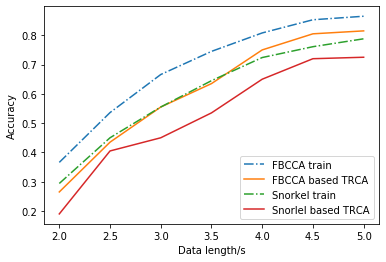

In [174]:
i = 2
plt.plot(x,train[:,i],label='FBCCA train',linestyle='-.')
plt.plot(x,test[:,i],label='FBCCA based TRCA')

plt.plot(x,train[:,-1],label='Snorkel train',linestyle='-.')
plt.plot(x,test[:,-1],label='Snorlel based TRCA')


plt.xlabel('Data length/s')
plt.ylabel('Accuracy')
plt.legend()

In [180]:
valid_subject_test = np.delete(testAcc,bad_sub_index,axis=-1)
valid_subject_train = np.delete(trainAcc,bad_sub_index,axis=-1)

test = np.mean(valid_subject_test,axis=-1)
train = np.mean(valid_subject_train,axis=-1)

# test = np.mean(testAcc[:,:,bad_sub_index],axis=-2)
# train = np.mean(trainAcc[:,:,bad_sub_index],axis=-2)


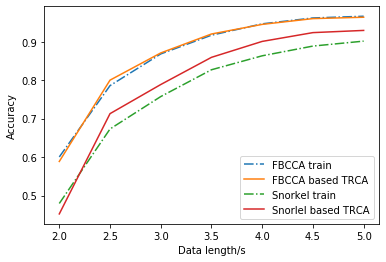

In [184]:
plt.plot(x,train[:,2],label='FBCCA train',linestyle='-.')
plt.plot(x,test[:,2],label='FBCCA based TRCA')

plt.plot(x,train[:,-1],label='Snorkel train',linestyle='-.')
plt.plot(x,test[:,-1],label='Snorlel based TRCA')
plt.xlabel('Data length/s')
plt.ylabel('Accuracy')
plt.legend()

对一般的方法，比如CCA和fft，有很大提升。但对于FBCCA，没多少帮助。

## 是不是所有人都这样？

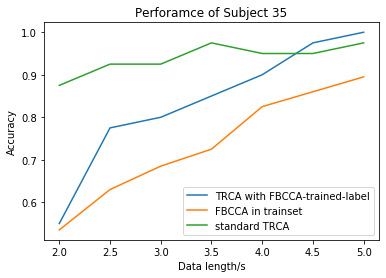

In [198]:

sub=34
meth=2
keys = np.linspace(2,5,7)
plt.plot(keys,testAcc[:,meth,sub],label='TRCA with FBCCA-trained-label')
plt.plot(keys,trainAcc[:,meth,sub],label='FBCCA in trainset')
plt.plot(keys,testAcc[:,0,sub],label='standard TRCA')
plt.xlabel('Data length/s')
plt.ylabel('Accuracy')
plt.title('Perforamce of Subject 35')
plt.legend()

# population-level analsis

1. 几乎没有差别：FBCCA很好，有训练反而没有有训练好？
2. 真实的标签不是真值。———弱监督中的不准确标记问题
3. 随之而来的还有训练数据不均衡的问题。

## snorkel method

In [61]:
testAcc = np.squeeze(testAcc[:,-1,:,:])
trainAcc = np.squeeze(trainAcc[:,-1,:,:])

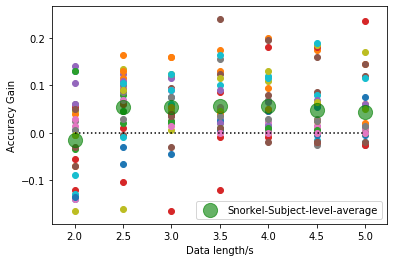

In [202]:
gain = testAcc - trainAcc
gain_submean = np.mean(gain,axis=-1)
gain_submean.shape
SubNUM = 35

bad_sub_index = np.argwhere(np.all(gain[:,2,:]<0.02,axis=0))
# 删除无效被试
valid_subject = np.delete(gain,bad_sub_index,axis=-1)
valid_gain_submean = np.mean(valid_subject,axis=-1)

for subInx in range(np.shape(valid_subject)[-1]):
    plt.scatter(x,valid_subject[:,-1,subInx])
plt.scatter(x,valid_gain_submean[:,-1],s=200,alpha=0.6,label='Snorkel-Subject-level-average',c='green')
plt.hlines(0,2,5,linestyles='dotted')

plt.xlabel('Data length/s')
plt.ylabel('Accuracy Gain')
plt.legend()

In [203]:
bad_sub_index+1

array([[ 2],
       [15],
       [21],
       [29],
       [30]])

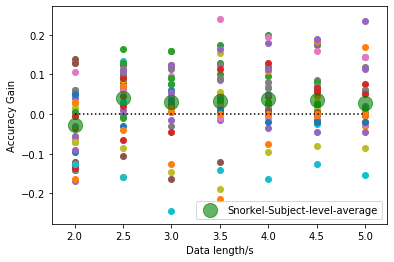

In [169]:
gain = testAcc - trainAcc
gain_submean = np.mean(gain,axis=-1)
gain_submean.shape
SubNUM = 35
for subInx in range(SubNUM):
    
    plt.scatter(x,gain[:,-1,subInx])
plt.scatter(x,gain_submean[:,-1],s=200,alpha=0.6,label='Snorkel-Subject-level-average',c='green')
plt.hlines(0,2,5,linestyles='dotted')
plt.xlabel('Data length/s')
plt.ylabel('Accuracy Gain')
plt.legend()

## CCA method

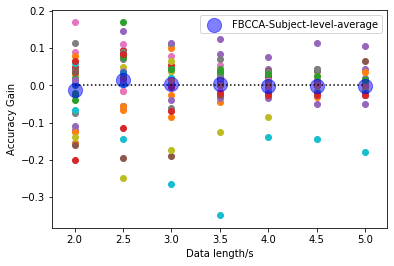

In [168]:
gain = testAcc - trainAcc
gain_submean = np.mean(gain,axis=-1)
for subInx in range(SubNUM):
    plt.scatter(x,gain[:,2,subInx])
plt.scatter(x,gain_submean[:,2],s=200,alpha=0.5,label='FBCCA-Subject-level-average',c='blue')
plt.hlines(0,2,5,linestyles='dotted')
plt.xlabel('Data length/s')
plt.ylabel('Accuracy Gain')
plt.legend()

## FBCCA method

In [138]:
# 无效被试，所有情况下不升反降
bad_expample = [] 
# 有效被试，在某种情况下正确率提升超过10%
valid_expample = []

for subInx in range(SubNUM):
    for methodInx in range(5):
        if np.all(gain[:,-1,subInx]<0):
            bad_expample.append(subInx) 
        if np.any(gain[:,-1,subInx]>0.1):
            valid_expample.append(subInx) 

In [139]:
invalid_sub = np.unique(bad_expample)
valid_sub = np.unique(valid_expample)

In [140]:
gain_exp_ave = []
for subInx in range(SubNUM):
    gain_exp_ave.append(max(gain[:,2,subInx]))
gain_exp_ave = np.stack(gain_exp_ave[i] for i in range(len(gain_exp_ave)))

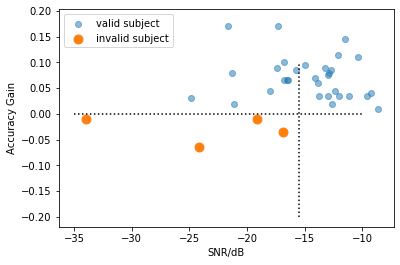

In [161]:
plt.scatter(SNR,gain_exp_ave,alpha=0.5,label='valid subject')
plt.scatter(SNR[bad_sub_index],gain_exp_ave[bad_sub_index],s=80,label='invalid subject')
plt.hlines(0,-35,-10,linestyles='dotted')
plt.vlines(-15.5,-0.20,0.10,linestyles='dotted')
plt.xlabel('SNR/dB')
plt.ylabel('Accuracy Gain')
plt.legend()

In [152]:
bad_sub_index

array([[ 1],
       [14],
       [28],
       [29]])

## 在所有的方法中，找到弱标签的阈值。

In [4]:

threshold_low = []
threshold_high = []

expNUM,methodNUM,subNUM = testAcc.shape
for subInx in range(SubNUM):
    for methodInx in np.arange(1,methodNUM):
        for expInx in range(expNUM):
            if gain[expInx,methodInx,subInx]<=0:
                threshold_low.append([
                    testAcc[expInx,methodInx,subInx],
                    trainAcc[expInx,methodInx,subInx],
                    expInx,methodInx,subInx
                ])
            if gain[expInx,methodInx,subInx]>=0.1:
                threshold_high.append([
                    testAcc[expInx,methodInx,subInx],
                    trainAcc[expInx,methodInx,subInx],
                    expInx,methodInx,subInx
                ])
threshold_low = np.stack(threshold_low[i] for i in range(len(threshold_low)))
# threshold_low = pd.DataFrame(threshold_low,columns=['test','train','expInx','methodInx','subInx'])

threshold_high = np.stack(threshold_high[i] for i in range(len(threshold_high)))
# threshold_high = pd.DataFrame(threshold_low,columns=['test','train','expInx','methodInx','subInx'])



ValueError: too many values to unpack (expected 3)

Text(0, 0.5, 'test accuracy')

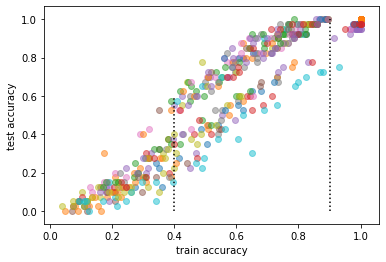

In [357]:

for subInx in range(subNUM):

    threshold_bot = threshold_low[threshold_low[:,-1]==subInx,:]
    threshold_top = threshold_high[threshold_high[:,-1]==subInx,:]
    
    threshold = np.vstack((threshold_bot,threshold_top))
    plt.scatter(threshold[:,1],threshold[:,0],label=str(subInx),alpha=0.5)

plt.vlines(0.4, 0, 0.6,color="black",linestyles='dotted')#横线
plt.vlines(0.9, 0, 1,color="black",linestyles='dotted')#横线


plt.xlabel('train accuracy')
plt.ylabel('test accuracy')



## 多长的时间窗可以？

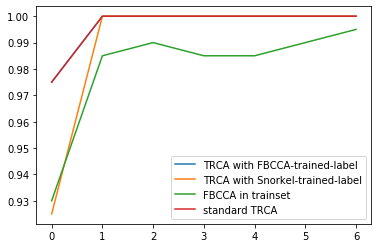

In [229]:

sub=5
meth=2
plt.plot(testAcc[:,meth,sub],label='TRCA with FBCCA-trained-label')
plt.plot(testAcc[:,-1,sub],label='TRCA with Snorkel-trained-label')
plt.plot(trainAcc[:,meth,sub],label='FBCCA in trainset')
plt.plot(testAcc[:,0,sub],label='standard TRCA')

plt.legend()

In [208]:
test_fix_window = testAcc[-1,:]
test_fix_window.shape

(4, 5, 35)

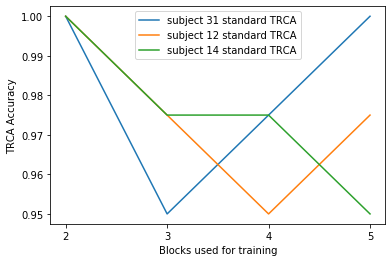

In [285]:

sub=12
meth=2
plt.plot([2,3,4,5],test_fix_window[:,0,31],label='subject 31 standard TRCA')
plt.plot([2,3,4,5],test_fix_window[:,0,sub],label='subject 12 standard TRCA')
plt.plot([2,3,4,5],test_fix_window[:,0,14],label='subject 14 standard TRCA')



ax=plt.gca()

x_major_locator=MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)

plt.xlabel('Blocks used for training')
plt.ylabel('TRCA Accuracy')


plt.legend()

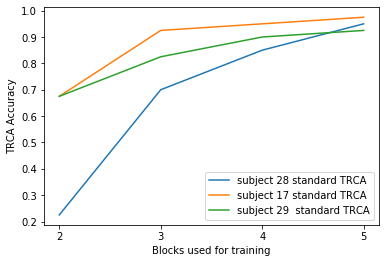

In [308]:

sub=12
meth=2

# plt.plot([2,3,4,5],test_fix_window[:,0,14],label='subject 14 standard TRCA')
plt.plot([2,3,4,5],test_fix_window[:,0,28],label='subject 28 standard TRCA')
plt.plot([2,3,4,5],test_fix_window[:,0,17],label='subject 17 standard TRCA')
plt.plot([2,3,4,5],test_fix_window[:,0,29],label='subject 29  standard TRCA')



ax=plt.gca()

x_major_locator=MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)

plt.xlabel('Blocks used for training')
plt.ylabel('TRCA Accuracy')


plt.legend()

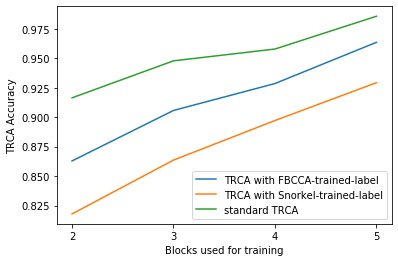

In [259]:

test_fix_window_ave = np.mean(test_fix_window,axis=-1)
sub=2
meth=2
plt.plot([2,3,4,5],test_fix_window_ave[:,meth],label='TRCA with FBCCA-trained-label')
plt.plot([2,3,4,5],test_fix_window_ave[:,-1],label='TRCA with Snorkel-trained-label')
plt.plot([2,3,4,5],test_fix_window_ave[:,0],label='standard TRCA')

ax=plt.gca()

x_major_locator=MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)

plt.xlabel('Blocks used for training')
plt.ylabel('TRCA Accuracy')

plt.legend()

In [114]:
window = []
for methdodInx in [2,-1]:
    for subInx in range(subNUM):
        for expInx in range(expNUM):
            if testAcc[expInx,methdodInx,subInx]>=testAcc[expInx,0,subInx]:
                window.append([expInx,methdodInx,subInx,testAcc[expInx,methdodInx,subInx],testAcc[expInx,0,subInx]])
window = np.stack(window[i] for i in range(len(window)))

In [232]:
valid_sub = np.unique(window[:,2]) 
window_report = np.ones((len(valid_sub),2))*-1

for i,subInx in enumerate(valid_sub):
    temp = window[window[:,2]==subInx,:]
    # Snorkel 需要的最短窗长度
    if temp[temp[:,1]==-1,0] !=[]:
        window_report[i,0] = min(temp[temp[:,1]==-1,0])
    # FBCCA 需要的最短窗长度
    if temp[temp[:,1]==2,0] !=[]:
        window_report[i,1] = min(temp[temp[:,1]==2,0])


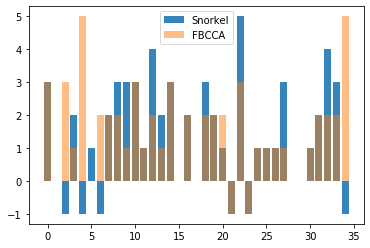

In [235]:

plt.bar(valid_sub,window_report[:,0],label='Snorkel',alpha=0.9)
plt.bar(valid_sub,window_report[:,1],label='FBCCA',alpha=0.5)
plt.legend()


## 要积累多少个block才可以？

In [4]:
datadir = 'report/split'
data_list = sorted(os.listdir(path=datadir))
if '.DS_Store' in data_list:
    data_list.remove('.DS_Store')

trainAcc = []
testAcc = []
trainLabel = []
testLabel = []

for filename in data_list:
    if filename.split('.')[-1] == 'npy':
        path=os.path.join(datadir, filename)
        REPORT = np.load(path,allow_pickle=True).item()

        trainAcc.append(REPORT['train_acc'])
        testAcc.append(REPORT['test_acc'])
        trainLabel.append(REPORT['TrainLabel'])
        testLabel.append(REPORT['TestLabel'])

trainAcc = np.stack(trainAcc[i] for i in range(len(trainAcc)))
testAcc = np.stack(testAcc[i] for i in range(len(testAcc)))


In [5]:
train.shape

NameError: name 'train' is not defined

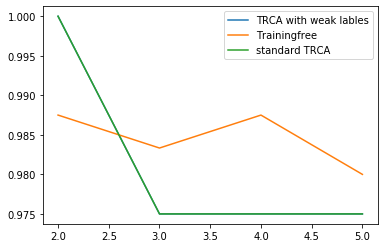

In [6]:

sub=11
meth=-1
x = [2,3,4,5]
# test = np.mean(testAcc,axis=-1)
# train = np.mean(trainAcc,axis=-1)

plt.plot(x,testAcc[:,meth,sub],label='TRCA with weak lables')
plt.plot(x,trainAcc[:,meth,sub],label='Trainingfree')
plt.plot(x,testAcc[:,0,sub],label='standard TRCA')

plt.legend()

1. 无训练是不受“训练数据量影响的”
2. 随着训练数据量的提升，TRCA训练效果是提高的，和标准TRCA的差距缩小
3. 对于Snorkel方法,至少要积累四个block的数据才能显著超过无训练
4. 在人均意义上，冷启动的方法没有超过FBCCA


每个人至少需要多长的窗长和多少个block？

In [11]:
gain = testAcc-trainAcc
threshold_low = []
threshold_high = []

for subInx in range(subNUM):
    for methodInx in np.arange(1,methodNUM):
        for windowInx in range(windowNUM):
            for blockInx in range(blockNUM):
                if gain[windowInx,blockInx,methodInx,subInx]<=0:
                    threshold_low.append([
                        subInx,methodInx,windowInx,blockInx,
                        testAcc[windowInx,blockInx,0,subInx],
                        testAcc[windowInx,blockInx,methodInx,subInx],
                        trainAcc[windowInx,blockInx,methodInx,subInx]
                    ])
                if gain[windowInx,blockInx,methodInx,subInx]>=0.1:
                    threshold_high.append([
                        subInx,methodInx,windowInx,blockInx,
                        testAcc[windowInx,blockInx,0,subInx],
                        testAcc[windowInx,blockInx,methodInx,subInx],
                        trainAcc[windowInx,blockInx,methodInx,subInx]
                    ])


threshold_low = np.stack(threshold_low[i] for i in range(len(threshold_low)))
threshold_high = np.stack(threshold_high[i] for i in range(len(threshold_high)))


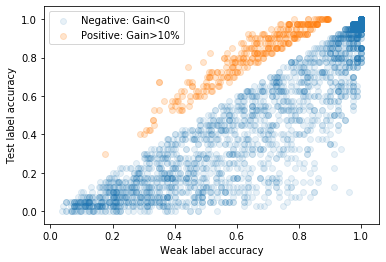

In [12]:
plt.scatter(threshold_low[:,6],threshold_low[:,5],alpha=0.1,label='Negative: Gain<0')
plt.scatter(threshold_high[:,6],threshold_high[:,5],alpha=0.2,label='Positive: Gain>10%')
plt.xlabel('Weak label accuracy')
plt.ylabel('Test label accuracy')

plt.legend()

Text(0, 0.5, 'Test label accuracy')

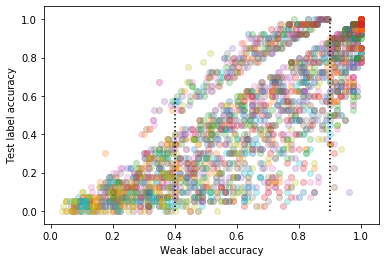

In [21]:
for subInx in range(subNUM):

    threshold_bot = threshold_low[threshold_low[:,0]==subInx,:]
    threshold_top = threshold_high[threshold_high[:,0]==subInx,:]
    
    threshold = np.vstack((threshold_bot,threshold_top))
    plt.scatter(threshold[:,4],threshold[:,3],label=str(subInx),alpha=0.25)

plt.vlines(0.4, 0, 0.6,color="black",linestyles='dotted')#横线
plt.vlines(0.9, 0, 1,color="black",linestyles='dotted')#横线


plt.xlabel('Weak label accuracy')
plt.ylabel('Test label accuracy')


In [28]:
# 要求是，要gain>0.1 的情况下，，每个被试至少需要多少个个block，多少组训练数据？
best_case = -5*np.ones((subNUM,2,2)) 

valid_sub = np.unique(threshold_high[:,0]) 
window_report = np.ones((len(valid_sub),2))*-1

for i,subInx in enumerate(valid_sub):
    temp = threshold_high[threshold_high[:,0]==subInx,:]
    # Snorkel 需要的最短窗长度和block数
    if temp[temp[:,1]==4,2] !=[]:
        best_case[i,0,0] = min(temp[temp[:,1]==4,2])
        best_case[i,0,1] = min(temp[temp[:,1]==4,3])
    # FBCCA 需要的最短窗长度和block数
    if temp[temp[:,1]==2,2] !=[]:
        best_case[i,1,0] = min(temp[temp[:,1]==2,2])
        best_case[i,1,1] = min(temp[temp[:,1]==2,3])


In [29]:
best_case[:,0,1]

array([-5.,  1., -5.,  1.,  3.,  1., -5.,  3., -5., -5., -5.,  2., -5.,
       -5., -5.,  3., -5., -5.,  2.,  3., -5., -5., -5., -5.,  3., -5.,
       -5., -5.,  1.,  3., -5., -5., -5., -5., -5.])

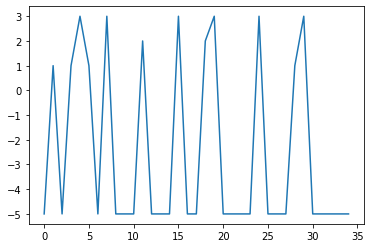

In [90]:
plt.plot(best_case[:,0,1])

In [13]:

threshold_high = []

for subInx in range(subNUM):
    for methodInx in np.arange(1,methodNUM):
        for windowInx in range(windowNUM):
            for blockInx in range(blockNUM):
                
                if gain[windowInx,blockInx,methodInx,subInx]>=0.1:
                    threshold_high.append([
                        subInx,methodInx,windowInx,blockInx,
                        testAcc[windowInx,blockInx,0,subInx],
                        testAcc[windowInx,blockInx,methodInx,subInx],
                        trainAcc[windowInx,blockInx,methodInx,subInx]
                    ])

threshold_high = np.stack(threshold_high[i] for i in range(len(threshold_high)))


In [14]:
close2TRCA = np.zeros(np.shape(testAcc))
for methodInx in np.arange(1,methodNUM):
   close2TRCA[:,:,methodInx,:] = testAcc[:,:,methodInx,:]-testAcc[:,:,0,:]
close2TRCA[:,:,0,:]= close2TRCA[:,:,0,:] - 100

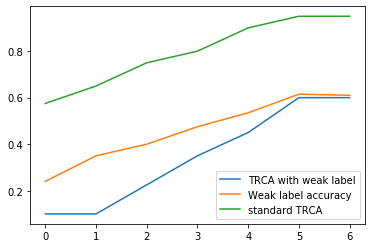

In [43]:

sub = 28
win = -1
meth = 2
plt.plot(testAcc[:,win,meth,sub],label='TRCA with weak label')
# plt.plot(testAcc[:,0,-1,sub],label='TRCA with Snorkel-trained-label')
plt.plot(trainAcc[:,win,meth,sub],label='Weak label accuracy')
plt.plot(testAcc[:,win,0,sub],label='standard TRCA')

plt.legend()

In [90]:
gain.shape

(7, 4, 5, 35)

In [16]:
cost = np.ones((subNUM,2))
for subInx in range(subNUM):
    for methodInx in [2,-1]:
        index1 = np.argwhere(close2TRCA[:,:,methodInx,subInx]>=0)
        index2 = np.argwhere(gain[:,:,methodInx,subInx]>=0)
        index = np.array([x for x in set(tuple(x) for x in index1) & set(tuple(x) for x in index2)])
        if index!=[]:
            sort = index[:,0]+index[:,1]
            cost[subInx,:] = index[sort.argsort()][0]

Text(0, 0.5, 'Subject Number')

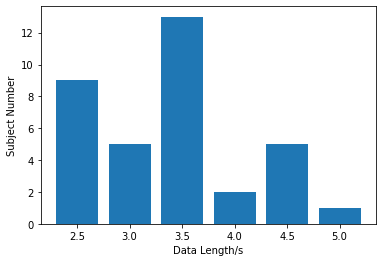

In [35]:
from collections import  Counter
window_list = Counter(cost[:,0])

window_list_values = np.array(list(window_list.values()))
window_list_keys = np.array(list(window_list.keys()))

keys = np.linspace(2,5,7)
keys = keys[window_list_keys.argsort()]
plt.bar(a,window_list_values,width=0.4)
plt.xlabel('Data Length/s')
plt.ylabel('Subject Number')


In [37]:
a=[]
keys = [2,3,4,5]
for i in range(len(window_list_keys)):
    a.append(keys[int(window_list_keys[i])])

In [40]:
window_list_keys

[0.0, 1.0, 2.0, 3.0]

Text(0, 0.5, 'Subject Number')

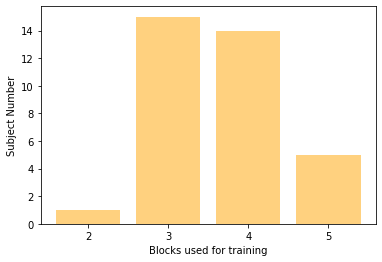

In [50]:
from collections import  Counter
from matplotlib.pyplot import MultipleLocator

window_list = Counter(cost[:,1])

window_list_values = list(window_list.values())
window_list_keys = list(window_list.keys())
plt.bar(a,window_list_values,color='orange',alpha=0.5)
ax=plt.gca()

x_major_locator=MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)

plt.xlabel('Blocks used for training')
plt.ylabel('Subject Number')

有多少人的TRCA反而没有弱监督的TRCA好？

array([0., 1., 2., 2., 2., 3., 1., 1., 3., 1., 1., 2., 2., 2., 2., 1., 2.,
       2., 2., 2., 3., 1., 1., 3., 1., 1., 2., 1., 1., 1., 1., 2., 2., 1.,
       3.])

In [128]:
index2

array([[1, 3],
       [2, 1],
       [2, 2],
       [2, 3],
       [3, 1],
       [3, 2],
       [3, 3],
       [4, 1],
       [4, 2],
       [4, 3],
       [5, 0],
       [5, 1],
       [5, 2],
       [5, 3],
       [6, 0],
       [6, 1],
       [6, 2],
       [6, 3]])